# XGBoost(eXtreme Gradient Boost)

XGBoost는 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나이다. GBM에 기반하고 있지만, GBM의 단점인 느린 수행 시간 및 과적합 규제(Regularization) 부재 등의 문제를 해결한 알고리즘이다.

#### XGBoost 주요 장점

* 뛰어난 예측 성능
* GBM 대비 빠른 수행 시간
* 과적합 규제(XGBoost 자체에 과적합 규제 기능으로 과적합에 좀 더 강한 내구성을 가짐)
* Tree prunnig(트리 가지치기) : 긍정 이득이 없는 분할을 가지치기해서 분할 수를 줄임.
* 자체 내장된 교차 검증 : 반복 수행 시마다 내부적으로 학습 데이터와 평가 데이터 세트에 대한 교차 검증 수행 -> 최적화된 반복 수행 횟수. 지정된 반복 횟수가 아닌 교차 검증을 통해 평가 데이터 세트의 평가 값이 최적화되면 반복을 중간에 멈출 수 있는 조기 중단 기능이 있음
* 결손값 자체 처리



In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

# XGBoost 하이퍼 파라미터

### 일반 파라미터
: 일반적으로 실행 시 스레드 수나 silent 모드 등의 선택을 위한 파라미터, 디폴트 파라미터 값을 바꾸는 경우는 거의 없다.

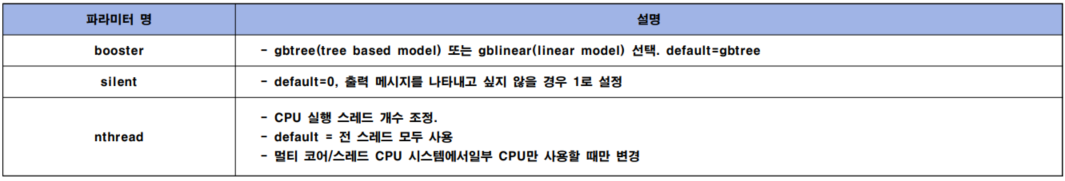

### 주요 부스터 파라미터
: 트리 최적화, 부스팅, regularization 등과 관련 파라미터 지칭

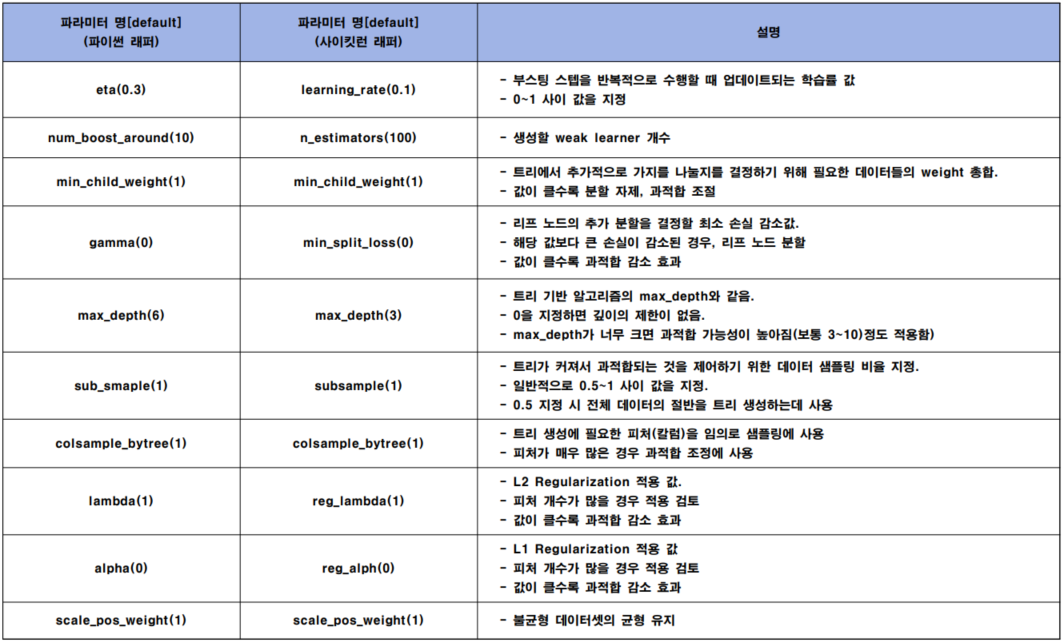

### 학습 태스크 파라미터
: 학습 수행 시의 객체 함수, 평가 지표 등을 설정

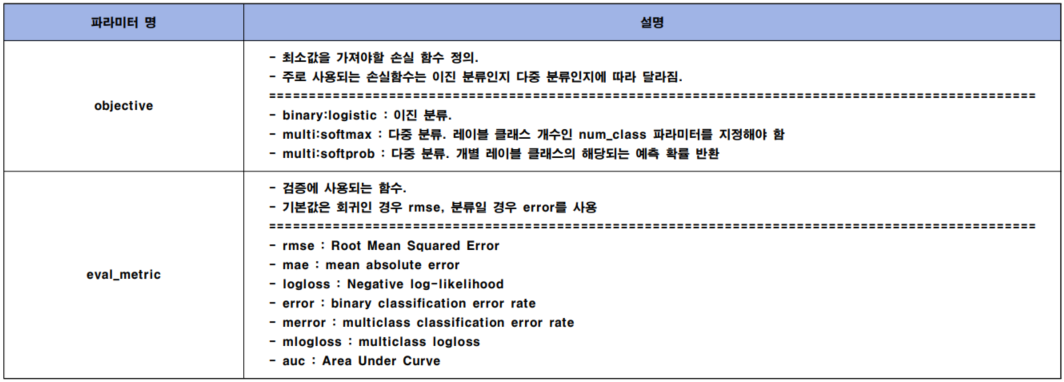

### 과적합 제어

* eta 값을 낮춘다. (0.01 ~ 0.1). eta 값을 낮출 경우 num_boost_round(또는 n_estimators)는 반대로 높여줘야한다.

* max_depth 값을 낮춘다.

* min_child_weight 값을 높인다.

* gamma 값을 높인다.

* subsample과 colsample_bytree를 낮추어 트리가 복잡하게 생성되는 것을 막는다.

In [2]:
# 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측
# XGBoost의 파이선 패키지인 xgboost는 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화 기능과 조기 중간 기능을 가지고 있음
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


종양의 크기와 모양에 관련된 많은 속성이 숫자형 값으로 되어있다. 타깃 레이블 값의 종류는 악성인 'malignant'가 0, 양성인 'benign' 값이 1로 되어있다.

In [4]:
print(dataset.target_names)
cancer_df['target'].value_counts()

['malignant' 'benign']


1    357
0    212
Name: target, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
X_train.shape, X_test.shape

((455, 30), (114, 30))

파이썬 래퍼 XGBoost는 사이킷런과의 가장 큰 차이는 학습용과 테스트 용 데이터 세트를 위해 별도 객체인 DMatrix를 생성한다는 점이다.

DMatrix : 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost 만의 전용 데이터 세트.

* 주요 입력 파라미터 : data(피처 데이터 세트), label(레이블 데이터 세트, 회귀의 경우 숫자형인 종속값 데이터 세트)
* 판다스의 DataFrame으로 데이터 인터페이스를 하기 위해서는 DataFrame.values를 이용해 넘파이로 일차 변환 뒤에 DMatrix 변환 적용

In [6]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터 세트를 DMatrix로 변환
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [7]:
# max_depth(트리 최대 깊이) = 3
# eta(학습률) = 0.1
# 예제가 이진분류이므로 objective(목적 함수)는 binary:logistic(이진 로지스틱)
# eval_metric(오류 함수의 평가 성능 지표) : logloss
# early_stoppings(조기 중단을 위한 최소 반복 횟수) : 100
# num_rounds(부스팅 반복 횟수) : 400
params = {
    'max_depth' : 3,
    'eta' : 0.1,
    'objective' : 'binary:logistic',
    'eval_metric' : 'logloss',
    'early_stoppings' : 100
}
num_rounds = 400

파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train() 함수에 파라미터 전달한다.(사이킷런의 경우 Estimator의 생성자를 하이퍼 파라미터로 전달)

**early_stopping_rounds** 파라미터 : 조기 중단을 위한 회소 반복 횟수 설정. 조기 중단을 수행하기 위해 eval_set과 eval_metric이 함께 설정되어야 한다.

* eval_set : 성능 평가를 위한 평가용 데이터 세트를 설정
* evel_metric : 평가 세트에 적용할 성능 평가 방법. 분류일 경우 주로 'error(분류 오류)', 'logloss'를 적용

반복 시마다 evel_set으로 지정된 데이터 세트에서 eval_metric의 지정된 평가 지표로 예측 오류 측정.

train() 함수를 호출하면 학습을 수행하고, 이때 반복 시마다 evals에 표시된 데이터 세트에 대한 평가 지표 결과가 출력된다. 그 후 학습이 완료된 모델 객체를 반환한다.

In [8]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

train()으로 학습을 수행하면 반복 시 train-logloss와 evel-logloss가 지속적으로 감소한다. xgboost를 이용해 모델 학습이 완료됐으면 이를 이용해 predict() 메서드로 테스트 데이터 세트에 예측을 수행해보자.

사이킷런의 predict() 메서드는 예측 결과 클래스 값(즉 0, 1)을 반환하는데 반해 xgboost의 predict9)는 예측 결과값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환한다.

In [9]:
pred_probs = xgb_model.predict(dtest)
print('predict()  수행 결과값 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정 -> preds 리스트에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print(preds[:10])

predict()  수행 결과값 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f} 정밀도 {1:.4f} 재현율 {2:.4f} F1 {3:.4f} AUC {4:.4f}\n'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.9737 정밀도 0.9744 재현율 0.9870 F1 0.9806 AUC 0.9951



xgboost의 plot_importance()를 사용하여 시각화 기능 수행.

plot_importance()는 피처의 중요도를 막대 그래프 형식으로 나타내며, 기본 평가 지표로 f1 스코어를 기반으로 각 feature 중요도를 나타낸다. 

사이킷런은 Estimator 객체의 feature_importances_ 속성을 이용해 직접 시각화 코드를 작성해야한다. 

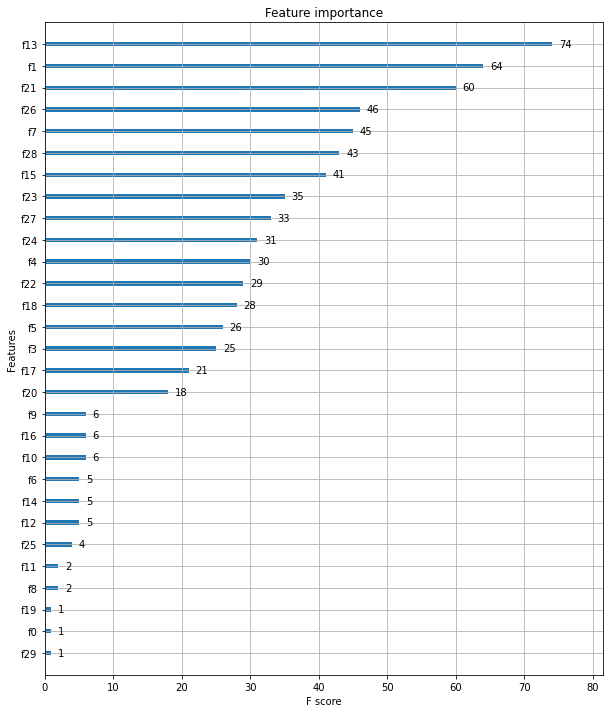

In [12]:
from  xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

plot_importance() 이용 시 유의할 점은 xgboost 넘파이 기반의 피처 데이터로 학습 시 피처명을 제대로 알 수 없어 피처 순서별로 f자 뒤에 숫자를 붙여 X 축에 피처들로 나열(즉, f0은 첫 번째 피처, f1은 두 번째 피처를 의미).

### 파이썬 래퍼의 교차 검증 수행 및 최적 파라미터 구하기
: xgboost는 사이킷런의 GridSearchCV와 유사하게 cv()를 API로 제공한다.

        xgb.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False,
        folds=None, metrics=(),obj=None, feval=None, maximize=False,
        early_stopping_rounds=None, fpreproc=None, as_pandas=True,
        verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)

* params(dict) : 부스터 파라미터
* dtrain(DMatrix) : 학습 데이터
* num_boost_round(int) : 부스팅 반복횟수
* nfold(int) : CV폴드 개수
* stratified(bool) : CV수행시 샘플을 균등하게 추출할지 여부
* metrics(string or list of strings) : CV수행 시 모니터링할 성능 평가 지표
* early_stopping_rounds(int) : 조기 중단을 활성화시킴. 반복 횟수 지정

xgb.cv() 의 반환값은 데이터프레임 형태


# 사이킷런 래퍼 XGBoost

사이킷런의 기본 Estimator를 그대로 상속하여 만들어졌기 때문에 다른 Estimator와 동일하게 fit()과 predict()만으로 학습과 예측이 가능하고, GridSearchCV, Pipeline 등 사이킷런의 다른 유틸리티를 그대로 사용할 수 있기 때문에 기존의 다른 머신러닝 알고리즘으로 만들어놓은 프로그램이 있더라도 알고리즘 클래스만 XGBoost 래퍼 클래스로 바꾸면 기존 프로그램을 그대로 사용할 수 있다.

XGBoost는 크게 분류를 위한 래퍼 클래스인 XGBClassifier, 회귀를 위한 래퍼 클래스인 XGBRegressor이다.

### 파이썬 래퍼와 비교 시 달라진 파라미터
* eta -> learning_rate
* sub_sample -> subsample
* lambda -> reg_lambda
* alpha -> reg_alpha
* num_boost_round -> n_estimators

In [13]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier
from xgboost import XGBClassifier
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [14]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.9737 정밀도 0.9744 재현율 0.9870 F1 0.9806 AUC 0.9951



이전 파이썬 래퍼 XGBoost와 동일한 결과가 나온다.

사이킷런 래퍼 XGBoost에서도 조기 중단을 수행할 수 있는데 fit()에 해당 파라미터를 입력하면 된다.

* early_stopping_rounds : 평가 지표가 향상될 수 있는 반복 횟수 지정
* eval_metric : 조기 중단을 위한 평가 지표
* eval_set : 성능 평가를 수행할 데이터 세트 - 학습 데이터가 아닌 별도의 데이터 세트

In [15]:
# early_stopping_rounds=100
# eval_metric='logloss'
# eval_set=테스트 데이터 세트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss',
                eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

n_estimators를 400으로 설정했지만 311번 반복한 후 학습을 완료했음을 알 수 있다. 211번 반복히 logloss가 0.085593이고 311번 반복 시 logloss가 0.085948인데, 211번에서 311번까지 early_stopping_rounds=100으로 지정된 100번의 반복동안 성능 평가 지수가 향상되지 않았기 때문에 더 이상 반복하지 않고 멈추게 되었다.

In [16]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도 : 0.9649 정밀도 0.9620 재현율 0.9870 F1 0.9744 AUC 0.9954



조기 중단 값을 너무 급격하게 줄이면 아직 성능이 향상될 여지가 있음에도 불구하고 학습을 멈추어 예측 성능이 저하될 수 있다.

In [17]:
# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


In [18]:
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도 : 0.9561 정밀도 0.9615 재현율 0.9740 F1 0.9677 AUC 0.9947



62번 반복까지만 수행된 후 학습이 종료되었는데, 62번 반복의 logloss가 0.090311, 52번 반복의 logloss가 0.089577로 10번의 반복동안 성능 평가 지수가 향상되지 못해서 더 이상 반복을 수행하지 않고 종료되었다. 

이렇게 학습된 모델로 예측한 결과 정확도는 약 0.9561로 early_stopping_rounds=100일 때의 약 0.9649보다 낮다.

모델 예측 후 피처 중요도를 동일하게 plot_importance() API를 통해 시각화.

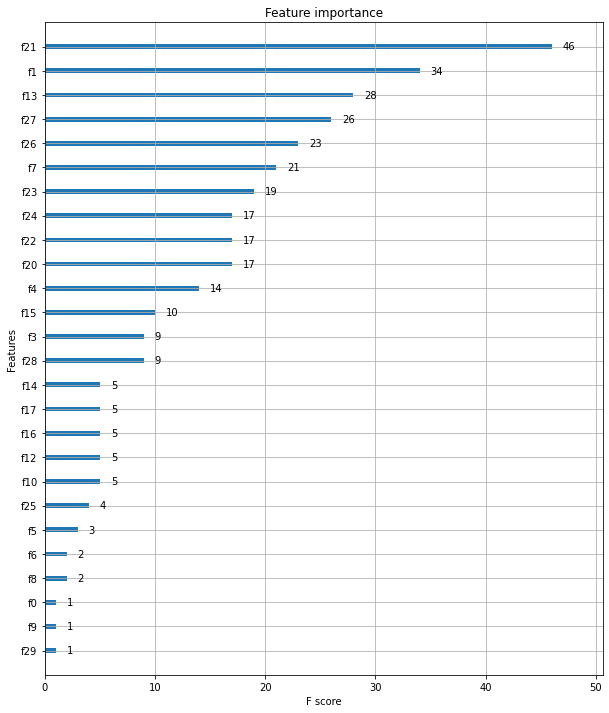

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)